In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
import logging
from tools.preprocess import load_datasets

logging.basicConfig(level=logging.ERROR, format="%(levelname)s - %(message)s")
logger = logging.getLogger()

In [2]:
train_dfs = load_datasets("datasetsCBR/mushroom/mushroom.fold.*.train.arff")
test_dfs = load_datasets("datasetsCBR/mushroom/mushroom.fold.*.test.arff")

print(f"\nNumber of training dataframes: {len(train_dfs)}")
print(f"Number of test dataframes: {len(test_dfs)}")
print()
train_dfs[0].head()


Number of training dataframes: 10
Number of test dataframes: 10



,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,b'f',b'y',b'y',b'f',b'f',b'f',b'c',b'b',b'h',b'e',...,b'b',b'p',b'p',b'w',b'o',b'l',b'h',b'v',b'g',b'p'
1,b'f',b's',b'b',b't',b'f',b'f',b'c',b'b',b'p',b't',...,b'w',b'w',b'p',b'w',b'o',b'p',b'h',b's',b'g',b'p'
2,b'x',b'y',b'g',b't',b'n',b'f',b'c',b'b',b'w',b'e',...,b'w',b'w',b'p',b'w',b't',b'p',b'w',b'y',b'p',b'e'
3,b'x',b'y',b'e',b't',b'n',b'f',b'c',b'b',b'n',b't',...,b'g',b'g',b'p',b'w',b'o',b'p',b'k',b'y',b'd',b'e'
4,b'x',b's',b'g',b'f',b'c',b'f',b'w',b'n',b'p',b'e',...,b'w',b'w',b'p',b'w',b'o',b'p',b'k',b's',b'd',b'p'


In [3]:
for df in train_dfs + test_dfs:
    for col in df.columns:
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])

train_dfs[0].head()

,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,2,3,9,0,2,1,0,0,3,0,...,0,6,0,2,1,2,1,4,1,1
1,2,2,0,1,2,1,0,0,7,1,...,7,7,0,2,1,4,1,3,1,1
2,5,3,3,1,5,1,0,0,10,0,...,7,7,0,2,2,4,7,5,4,0
3,5,3,2,1,5,1,0,0,5,1,...,3,3,0,2,1,4,2,5,0,0
4,5,2,3,0,1,1,1,1,7,0,...,7,7,0,2,1,4,2,3,0,1


In [4]:
preds = []
actuals = []

for train_df, test_df in zip(train_dfs, test_dfs):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(train_df.drop("class", axis=1), train_df["class"])
    preds.extend(decision_tree.predict(test_df.drop("class", axis=1)))
    actuals.extend(test_df["class"])

print(classification_report(actuals, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4208
           1       1.00      1.00      1.00      3916

    accuracy                           1.00      8124
   macro avg       1.00      1.00      1.00      8124
weighted avg       1.00      1.00      1.00      8124



In [5]:
feature_importances = pd.DataFrame(
    {
        "feature": train_dfs[0].drop("class", axis=1).columns,
        "importance": decision_tree.feature_importances_,
        "index": range(len(decision_tree.feature_importances_)),
    }
)
top_5_features = feature_importances.sort_values("importance", ascending=False).head(5)
print("Top 5 features:")
top_5_features

Top 5 features:


,feature,importance,index
8,gill-color,0.348878,8
19,spore-print-color,0.198661,19
20,population,0.177743,20
7,gill-size,0.125786,7
10,stalk-root,0.049064,10


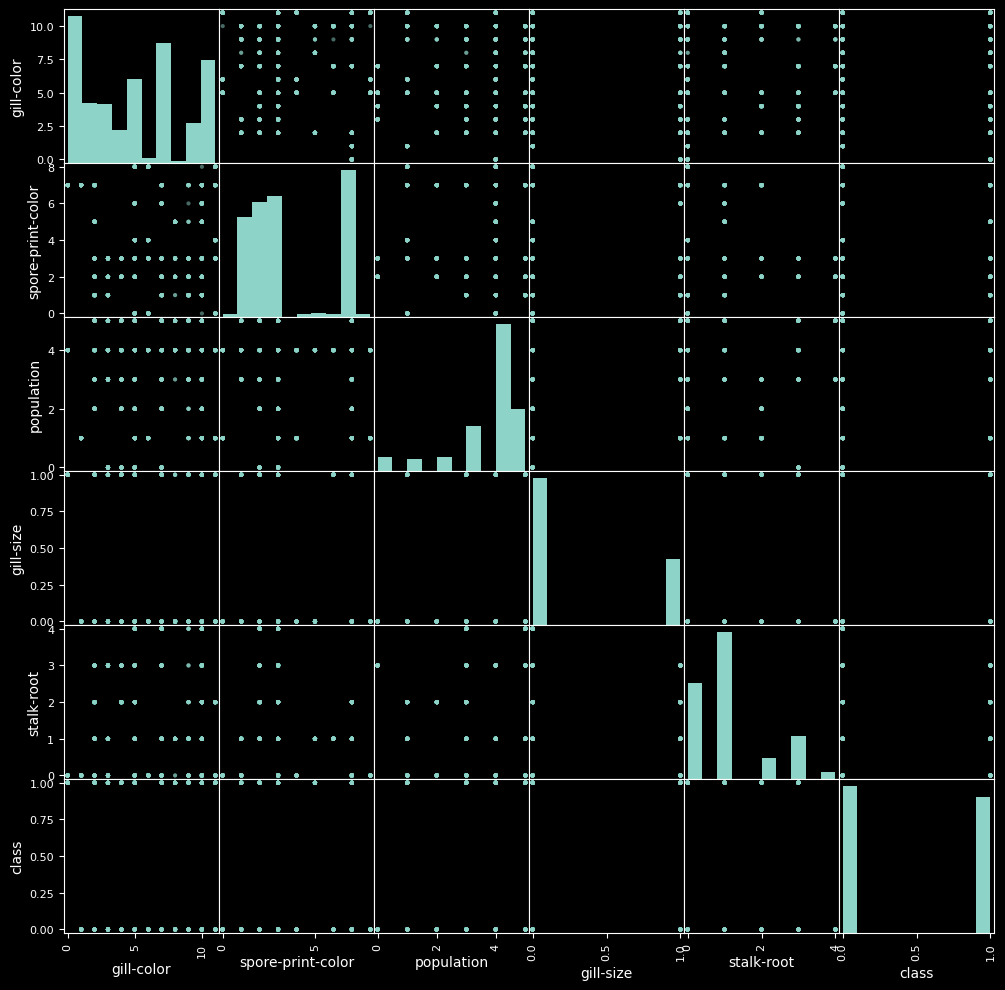

In [6]:
pd.plotting.scatter_matrix(
    pd.concat(train_dfs + test_dfs)[top_5_features.feature.values.tolist() + ["class"]],
    figsize=(12, 12),
)
plt.show()

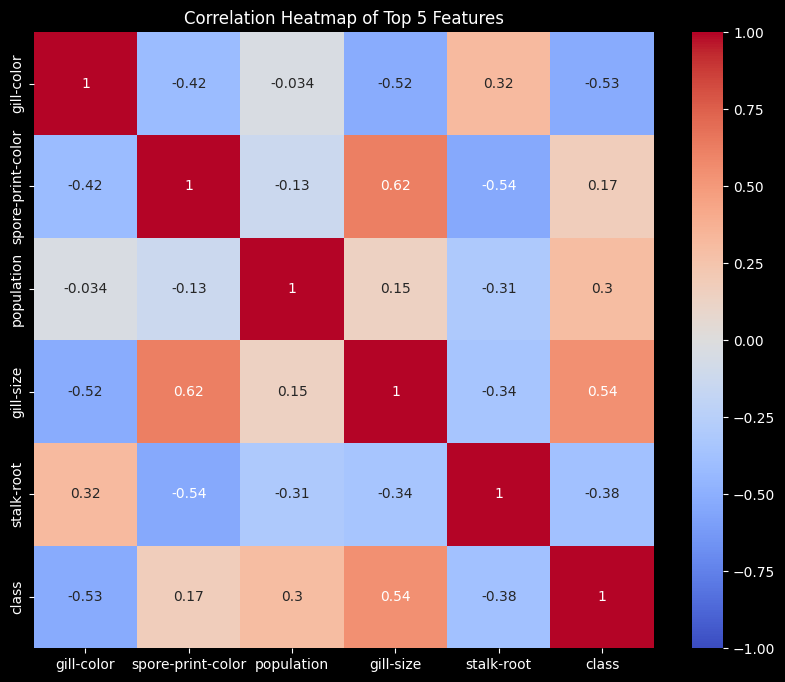

In [7]:
import seaborn as sns

top_5_features_and_class = top_5_features["feature"].tolist() + ["class"]
corr_matrix = pd.concat(train_dfs + test_dfs)[top_5_features_and_class].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Correlation Heatmap of Top 5 Features")
plt.show()